This notebook contains a set of common functions used to run the  experiments for model optimization and tuning in your exercise

In [2]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#---------------------------------------------------------------------
#Function to convert Flower names to numeric values
#---------------------------------------------------------------------
def type_to_numeric(x):
    if x=='setosa':
        return 0
    if x=='versicolor':
        return 1
    else :
        return 2

    

In [3]:
#---------------------------------------------------------------------
#Function to read data and process. Get ready for Deep Learning
#---------------------------------------------------------------------
def get_data():
    
    iris_data = pd.read_csv("iris.csv")
    
    iris_data.dtypes
    iris_data.describe()
    iris_data.head()
    
    #Use a Label encoder to convert String to numeric values for the target variable

    label_encoder = preprocessing.LabelEncoder()
    iris_data['Species'] = label_encoder.fit_transform(
                                    iris_data['Species'])
    
    #Convert input to numpy array
    np_iris = iris_data.to_numpy()
    
    #Separate feature and target variables
    X_data = np_iris[:,0:4]
    Y_data=np_iris[:,4]
    
    #Create a scaler model that is fit on the input data.
    scaler = StandardScaler().fit(X_data)
    
    #Scale the numeric feature variables
    X_data = scaler.transform(X_data)
    
    #Convert target variable as a one-hot-encoding array
    Y_data = tf.keras.utils.to_categorical(Y_data,3)

    #Return Feature and Target variables
    return X_data,Y_data

In [4]:
#---------------------------------------------------------------------
#Function to create the default configuration for the model. This will be overridden as 
#required during experimentation
#---------------------------------------------------------------------
def base_model_config():
    model_config = {
            "HIDDEN_NODES" : [32,64],
            "HIDDEN_ACTIVATION" : "relu",
            "OUTPUT_NODES" : 3,
            "OUTPUT_ACTIVATION" : "softmax",
            "WEIGHTS_INITIALIZER" : "random_normal",
            "BIAS_INITIALIZER" : "zeros",
            "NORMALIZATION" : "none",
            "OPTIMIZER" : "rmsprop",
            "LEARNING_RATE" : 0.001,
            "REGULARIZER" : None,
            "DROPOUT_RATE" : 0.0,
            "EPOCHS" : 100,
            "BATCH_SIZE" : 16,
            "VALIDATION_SPLIT" : 0.2,
            "VERBOSE" : 0,
            "LOSS_FUNCTION" : "categorical_crossentropy",
            "METRICS" : ["accuracy"]
            }
    return model_config

In [5]:
#---------------------------------------------------------------------
# Function to create an optimizer based on the optimizer name and learning rate
#---------------------------------------------------------------------
def get_optimizer(optimizer_name, learning_rate):
    #'sgd','rmsprop','adam','adagrad'
    optimizer=None
    
    if optimizer_name == 'adagrad': 
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)

    elif 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    elif'adam' :
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
    else :
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
            
    return optimizer

In [6]:
#---------------------------------------------------------------------
# Function to create a model and fit the model
#---------------------------------------------------------------------

def create_and_run_model(model_config,X,Y,model_name) :
    
    model=tf.keras.models.Sequential(name=model_name)
    
    for layer in range(len(model_config["HIDDEN_NODES"])):
        
        if (layer == 0):
            model.add(
                    keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    input_shape=(X.shape[1],),
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
        else:
            
            if ( model_config["NORMALIZATION"] == "batch"):
                model.add(keras.layers.BatchNormalization())
                
            if ( model_config["DROPOUT_RATE"] > 0.0 ):
                model.add(keras.layers.Dropout(model_config["DROPOUT_RATE"]))
                
            model.add(
                    keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"])) 
            

            
    model.add(keras.layers.Dense(model_config["OUTPUT_NODES"],
                    name="Output-Layer",
                    activation=model_config["OUTPUT_ACTIVATION"]))
    
    optimizer = get_optimizer( model_config["OPTIMIZER"],
                              model_config["LEARNING_RATE"])
    
    model.compile(loss=model_config["LOSS_FUNCTION"],
                  optimizer=optimizer,
                   metrics=model_config["METRICS"])
    
    print("\n******************************************************")
    model.summary()
    
    X_train, X_val, Y_train, Y_val =train_test_split(
                        X,Y,
                        stratify=Y,
                        test_size=model_config["VALIDATION_SPLIT"]) 
    
    history=model.fit(X_train,
          Y_train,
          batch_size=model_config["BATCH_SIZE"],
          epochs=model_config["EPOCHS"],
          verbose=model_config["VERBOSE"],
          validation_data= (X_val, Y_val))
    
    return history

In [7]:
#---------------------------------------------------------------------
#Function to plot a graph based on the results derived
#---------------------------------------------------------------------

def plot_graph(accuracy_measures, title):
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 8))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment], 
                 label=experiment,
                    linewidth=3)
        
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### **2.2 Epoch and Batch Sizes**

In [8]:
#Initialize the measures
accuracy_measures = {}

for batch_size in range(16,128,16):
    
    #Load default configuration
    model_config = base_model_config()
    #Acquire and process input data
    X,Y = get_data()
    
    #set epoch to 20
    model_config["EPOCHS"]=20
    #Set batch size to experiment value
    model_config["BATCH_SIZE"] = batch_size
    model_name = "Batch-Size-" + str(batch_size)
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Batch-Size-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,467
Trainable params: 2,467
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Batch-Size-32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)         

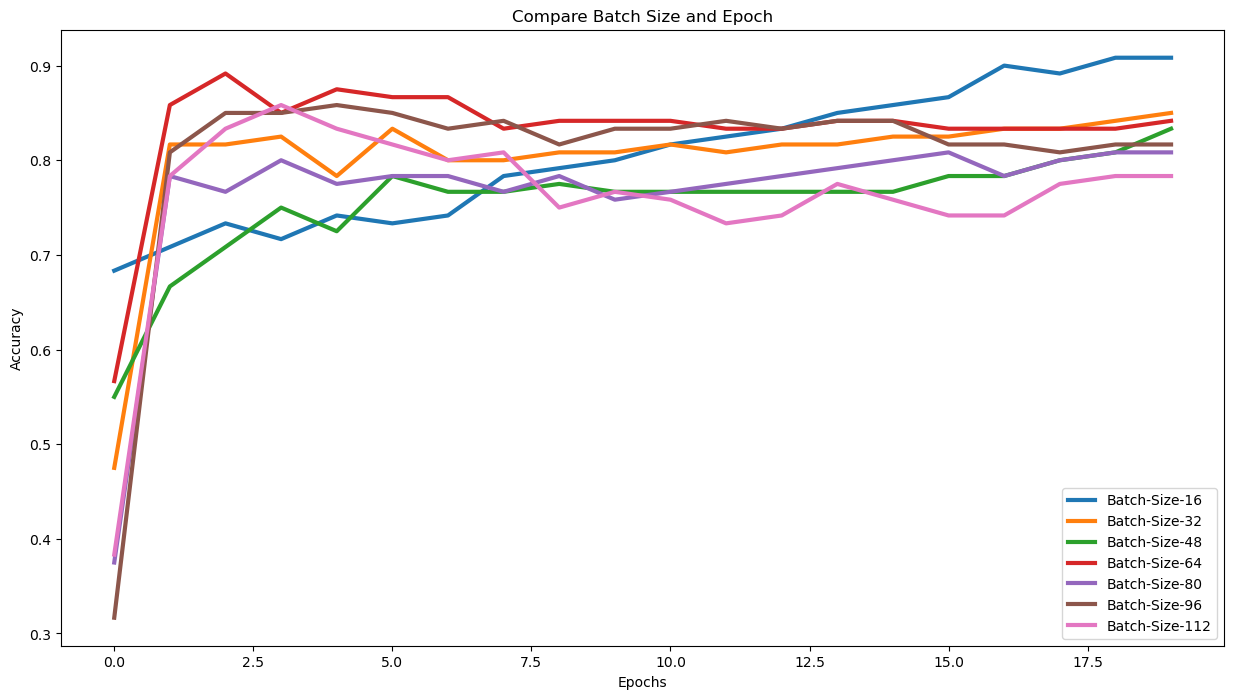

In [9]:
plot_graph(accuracy_measures, "Compare Batch Size and Epoch")

### **2.3. Layers in a Network**

In [10]:
accuracy_measures = {}
layer_list =[]
for layer_count in range(1,6):
    
    #32 nodes in each layer
    layer_list.append(32)
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_name = "Layers-" + str(layer_count)
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]



******************************************************
Model: "Layers-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Output-Layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Layers-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 32)                1056   

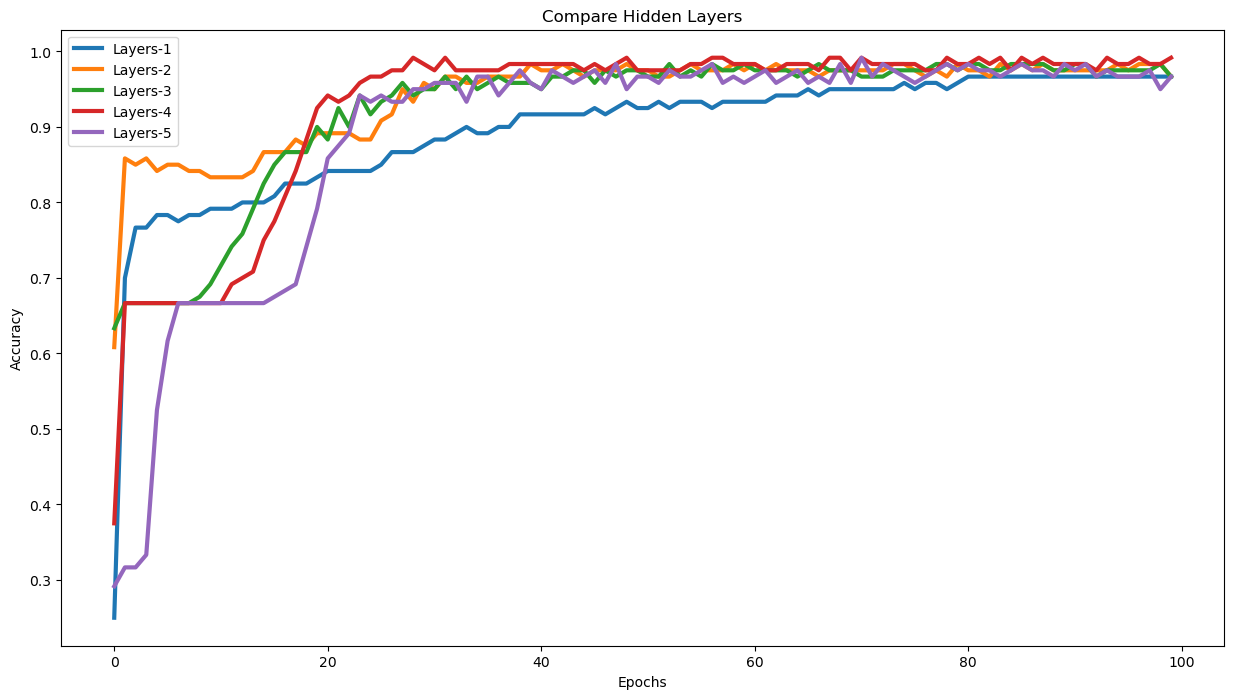

In [11]:
plot_graph(accuracy_measures, "Compare Hidden Layers")

### **2.4 Nodes in a Layer**

In [12]:
accuracy_measures = {}

for node_count in range(8,40,8):
    
    #have 2 hidden layers in the networks
    layer_list =[]
    for layer_count in range(2):
        layer_list.append(node_count)
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_name = "Nodes-" + str(node_count)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]



******************************************************
Model: "Nodes-8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 8)                 40        
                                                                 
 Dense-Layer-1 (Dense)       (None, 8)                 72        
                                                                 
 Output-Layer (Dense)        (None, 3)                 27        
                                                                 
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Nodes-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 16)                80      

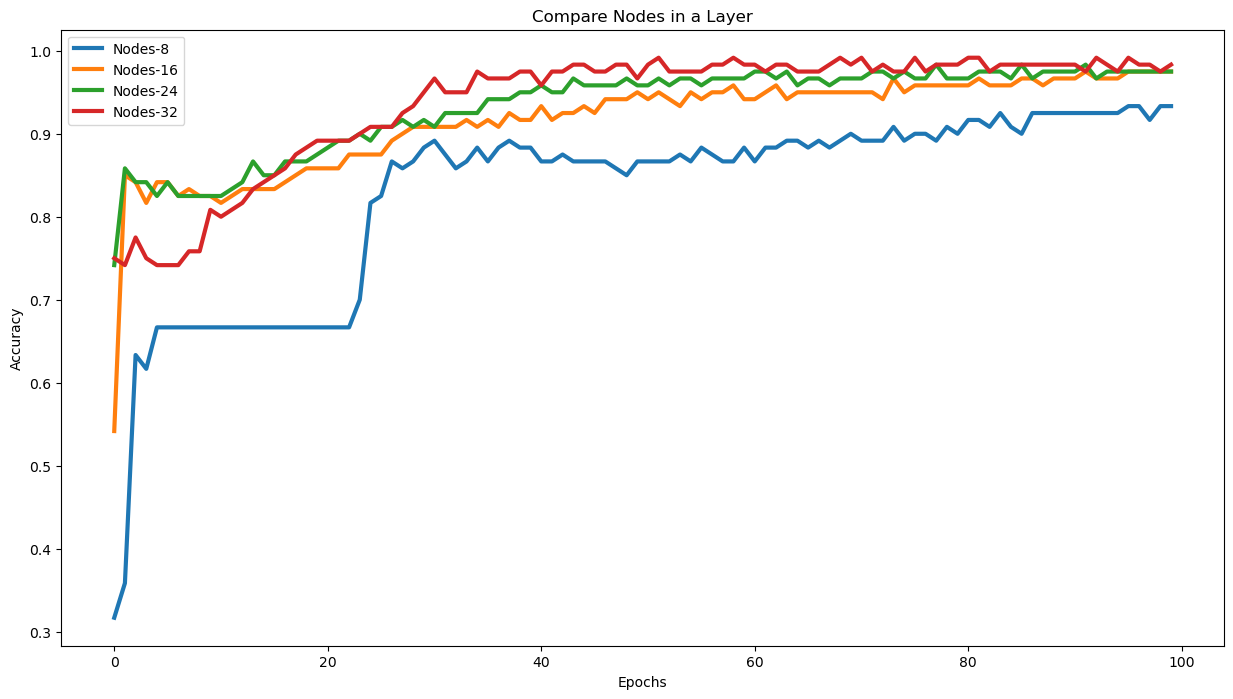

In [13]:
plot_graph(accuracy_measures, "Compare Nodes in a Layer")

### **2.5 Choosing Activation Functions**

In [14]:
accuracy_measures = {}

activation_list = ['relu','sigmoid','tanh']

for activation in activation_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["HIDDEN_ACTIVATION"] = activation
    model_name = "Model-" + activation
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures["Model-" + activation] = history.history["accuracy"]



******************************************************
Model: "Model-relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,467
Trainable params: 2,467
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Model-sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)            

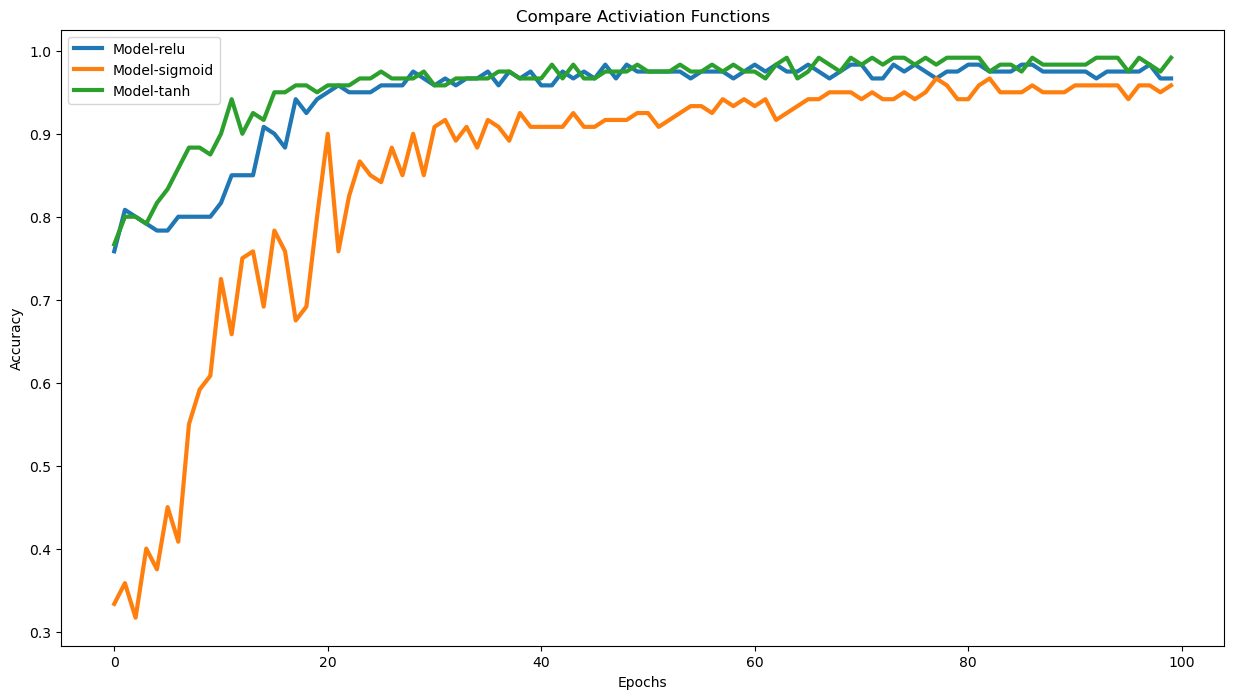

In [15]:
plot_graph(accuracy_measures, "Compare Activiation Functions")

### **2.6. Weights Initialization**

In [16]:
accuracy_measures = {}

initializer_list = ['random_normal','zeros','ones',"random_uniform"]
for initializer in initializer_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["WEIGHTS_INITIALIZER"] = initializer
    model_name = "Model-" + initializer
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Model-random_normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,467
Trainable params: 2,467
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Model-zeros"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)     

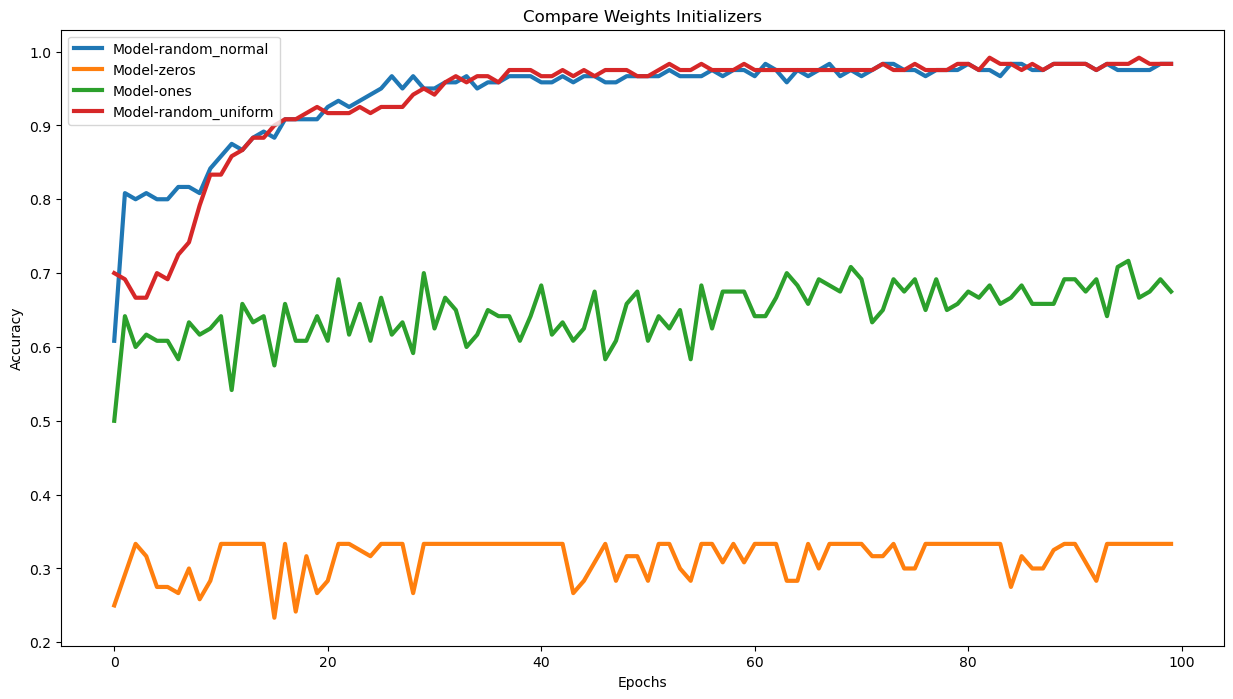

In [17]:
plot_graph(accuracy_measures, "Compare Weights Initializers")

### **3.2. Batch Normalization**

In [18]:
accuracy_measures = {}

normalization_list = ['none','batch']
for normalization in normalization_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["NORMALIZATION"] = normalization
    model_name="Normalization-" + normalization
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]



******************************************************
Model: "Normalization-none"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,467
Trainable params: 2,467
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Normalization-batch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 3

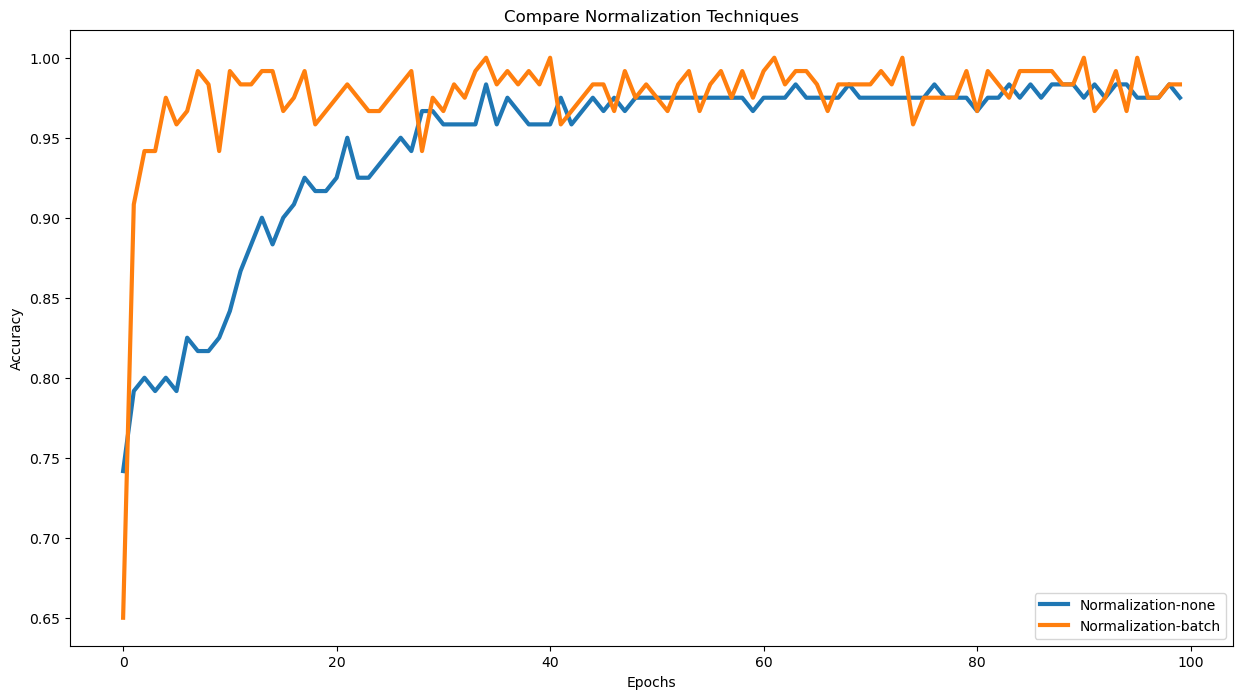

In [19]:
plot_graph(accuracy_measures, "Compare Normalization Techniques")

### **3.4 Optimizers**

In [20]:
accuracy_measures = {}

optimizer_list = ['sgd','rmsprop','adam','adagrad']
for optimizer in optimizer_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["OPTIMIZER"] = optimizer
    model_name = "Optimizer-" + optimizer
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Optimizer-sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,467
Trainable params: 2,467
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Optimizer-rmsprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)     

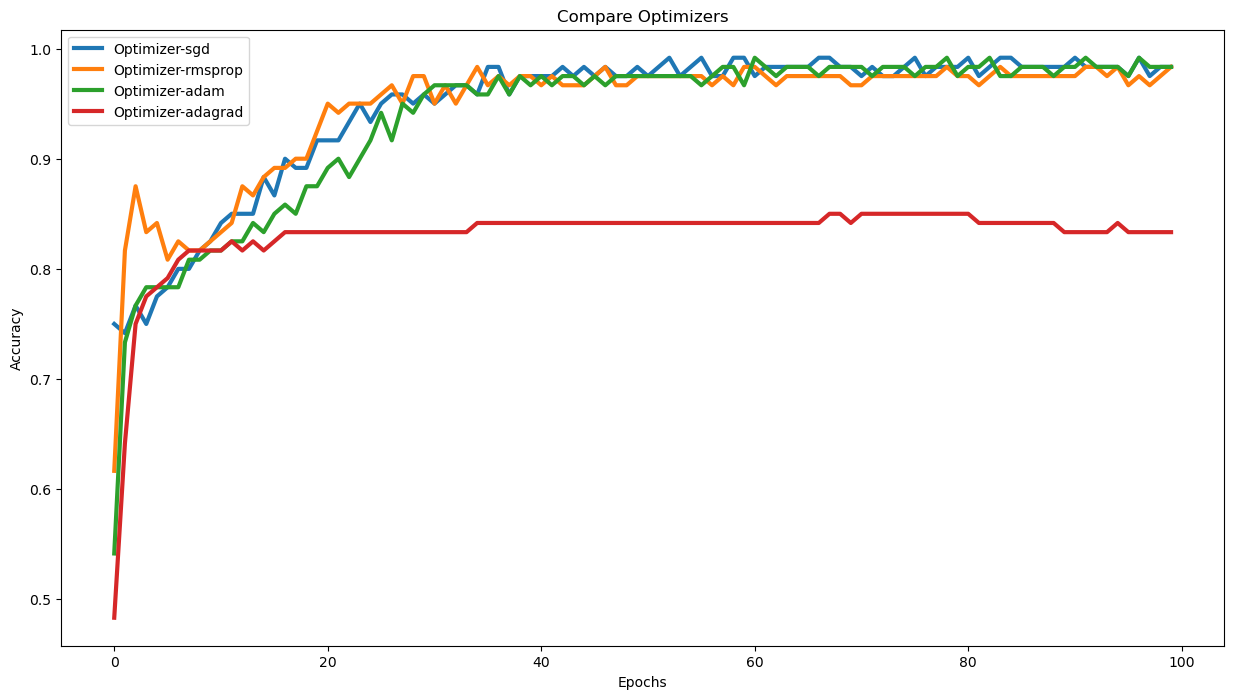

In [21]:
plot_graph(accuracy_measures, "Compare Optimizers")

### **3.6. Learning Rates**

In [22]:
accuracy_measures = {}

learning_rate_list = [0.001, 0.005,0.01,0.1,0.5]
for learning_rate in learning_rate_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["LEARNING_RATE"] = learning_rate
    model_name="Learning-Rate-" + str(learning_rate)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #accuracy
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Learning-Rate-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,467
Trainable params: 2,467
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Learning-Rate-0.005"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 

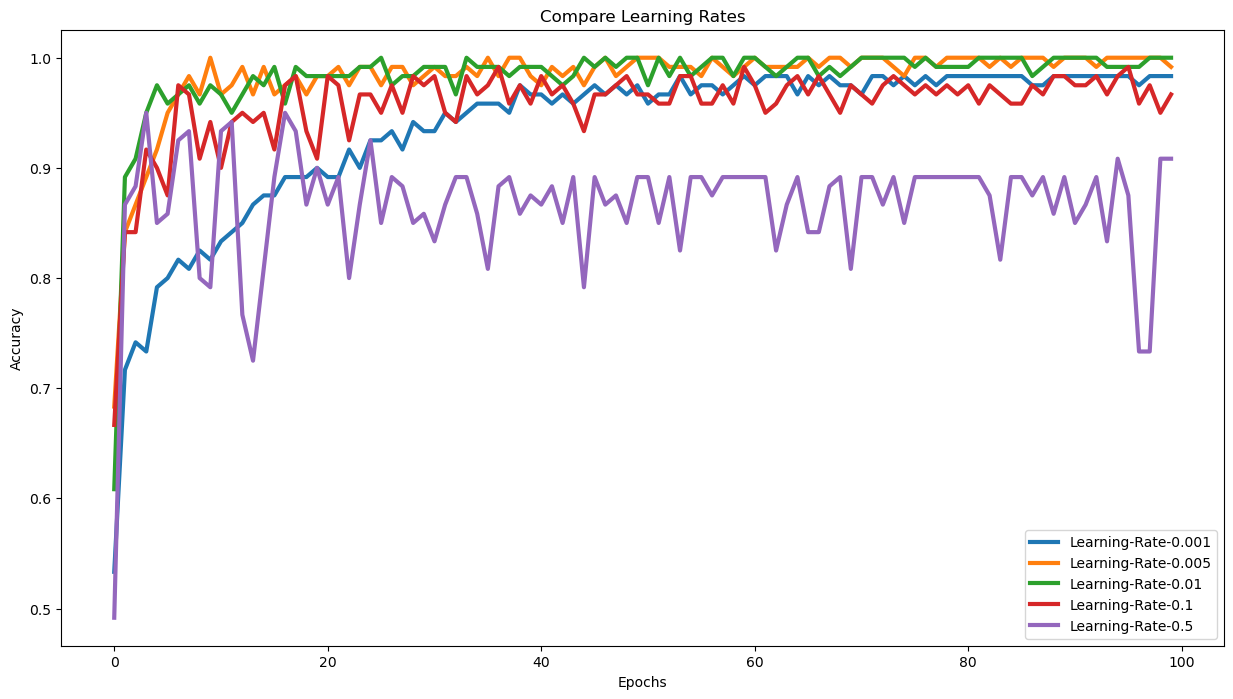

In [23]:
plot_graph(accuracy_measures, "Compare Learning Rates")

### **4.3. Regularization**

In [24]:
accuracy_measures = {}

regularizer_list = ['l1','l2','l1_l2']
for regularizer in regularizer_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["REGULARIZER"] = regularizer
    model_config["EPOCHS"]=25
    model_name = "Regularizer-" + regularizer
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #Switch to validation accuracy
    accuracy_measures[model_name] = history.history["val_accuracy"]


******************************************************
Model: "Regularizer-l1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,467
Trainable params: 2,467
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Regularizer-l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)       

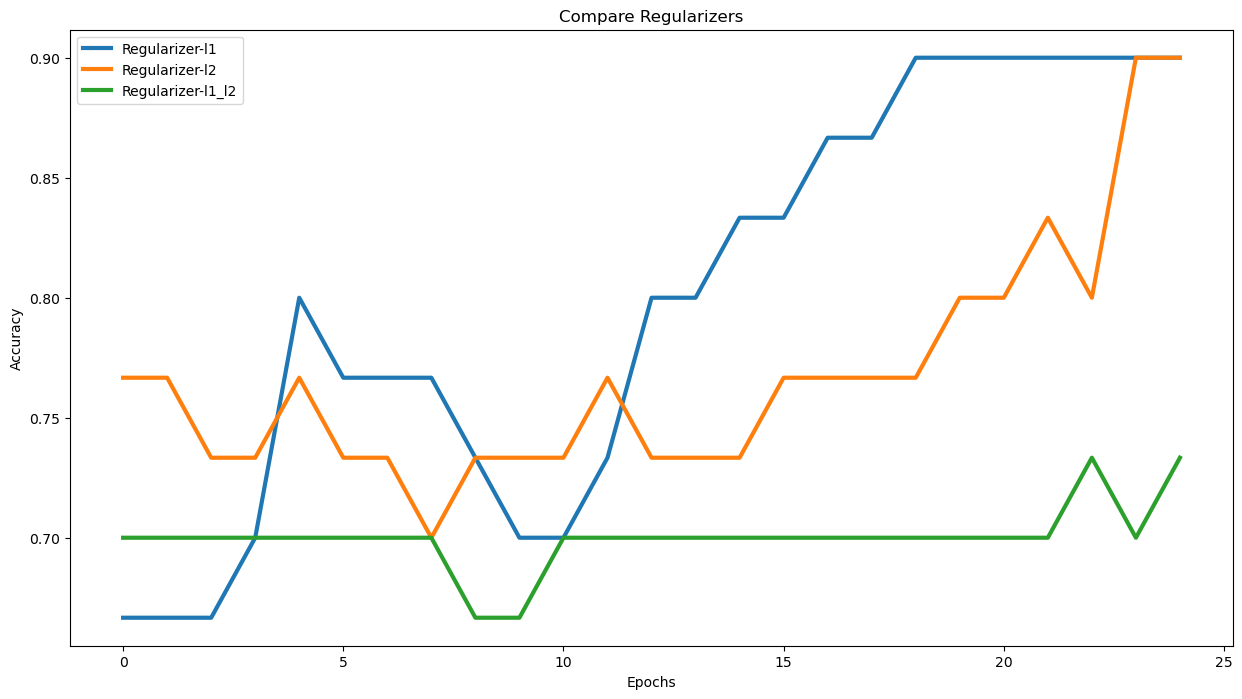

In [25]:
plot_graph(accuracy_measures, "Compare Regularizers")

### **4.5. Dropout**

In [26]:
accuracy_measures = {}

dropout_list = [0.0, 0.1, 0.2, 0.5]
for dropout in dropout_list:
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["DROPOUT_RATE"] = dropout
    model_config["EPOCHS"]=25
    model_name="Dropout-" + str(dropout)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #Using validation accuracy
    accuracy_measures[model_name] = history.history["val_accuracy"]


******************************************************
Model: "Dropout-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,467
Trainable params: 2,467
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Dropout-0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)             

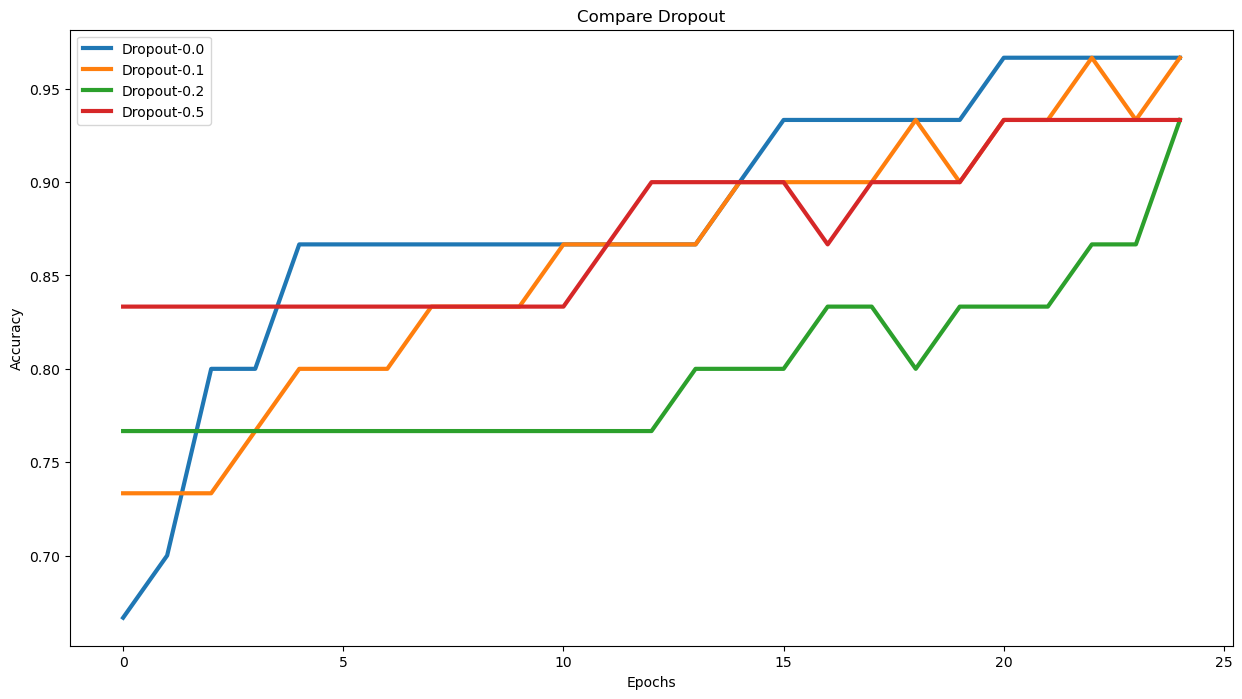

In [27]:
plot_graph(accuracy_measures, "Compare Dropout")

### Building the final **model**

In [62]:
accuracy_measures = {}

#Base Minimal Model (PLEASE DON'T CHANGE THIS BASE MODEL)#
model_config = base_model_config()                       #
model_config["HIDDEN_NODES"] = [16]                      #
model_config["NORMALIZATION"] = None                     #
model_config["OPTIMIZER"] = "adam"                       #
model_config["LEARNING_RATE"] = 0.1                      #
model_config["REGULARIZER"] = None                       #
model_config["DROPOUT_RATE"] = 0.0                       #
#Base Minimal Model (PLEASE DON'T CHANGE THIS BASE MODEL)#

X,Y = get_data()

model_name = "Base-Model-" + str(layer_count)

history=create_and_run_model(model_config,X,Y,model_name)
    
accuracy_measures[model_name] = history.history["accuracy"]

#Adding all optimizations (Here is where you put your parameters)
model_config = base_model_config()
model_config["HIDDEN_NODES"] = [32,32]
model_config["NORMALIZATION"] = None
model_config["LEARNING_RATE"] = 0.01
model_config["REGULARIZER"] = None
model_config["DROPOUT_RATE"] = 0.0
model_config["BATCH_SIZE"] = 16
model_config["EPOCHS"] = 600
model_config["OPTIMIZER"] = "sgd"
model_config["VALIDATION_SPLIT"] = 0.1

X,Y = get_data()

model_name = "Optimized-Model-" + str(layer_count)

history=create_and_run_model(model_config,X,Y,model_name)
    
accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Base-Model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 16)                80        
                                                                 
 Output-Layer (Dense)        (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Optimized-Model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 32)          

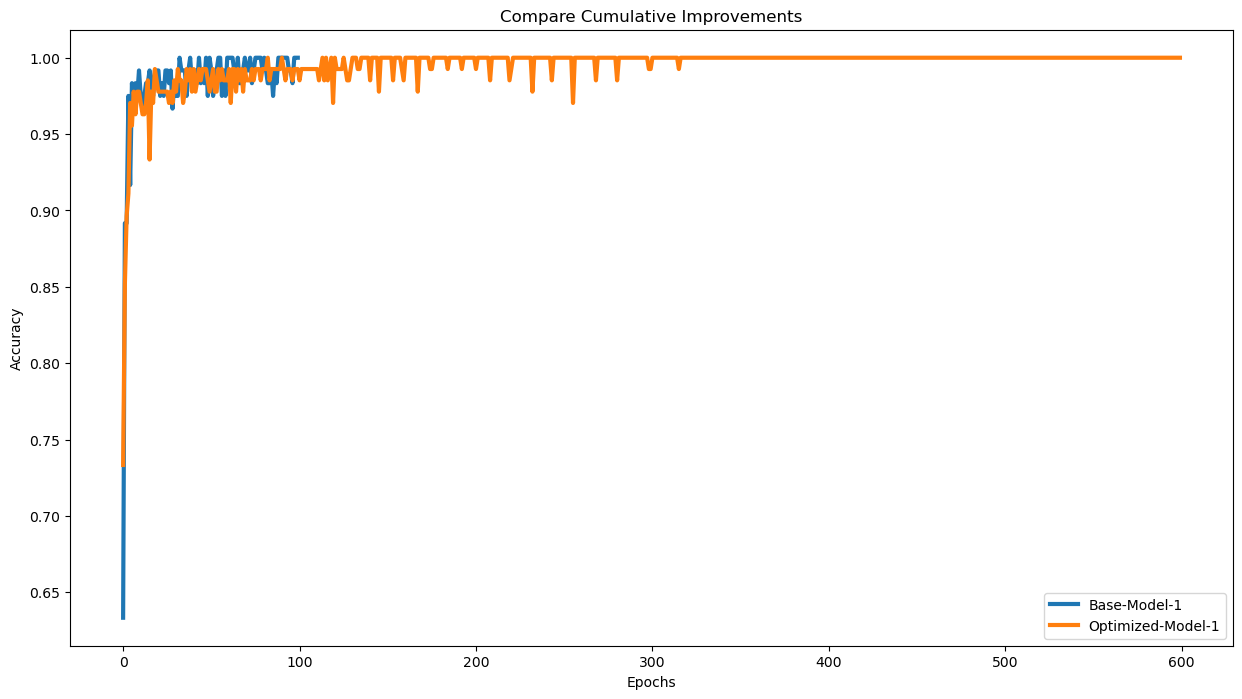

In [63]:
plot_graph(accuracy_measures, "Compare Cumulative Improvements")

In [64]:
print(accuracy_measures["Optimized-Model-1"])

[0.7333333492279053, 0.8518518805503845, 0.8962963223457336, 0.9111111164093018, 0.970370352268219, 0.9555555582046509, 0.9777777791023254, 0.9629629850387573, 0.9777777791023254, 0.9777777791023254, 0.970370352268219, 0.9629629850387573, 0.9629629850387573, 0.970370352268219, 0.9851852059364319, 0.9333333373069763, 0.9777777791023254, 0.970370352268219, 0.9925925731658936, 0.9851852059364319, 0.9777777791023254, 0.9777777791023254, 0.9777777791023254, 0.9777777791023254, 0.9777777791023254, 0.9777777791023254, 0.970370352268219, 0.9777777791023254, 0.970370352268219, 0.9851852059364319, 0.9777777791023254, 0.9925925731658936, 0.9851852059364319, 0.9851852059364319, 0.970370352268219, 0.9777777791023254, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9777777791023254, 0.9925925731658936, 0.9777777791023254, 0.9851852059364319, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9851852059364319, 0.9777777791023254, 0.9851

In [65]:
from statistics import mean 

inp_lst = [0.7333333492279053, 0.8518518805503845, 0.8962963223457336, 0.9111111164093018, 0.970370352268219, 0.9555555582046509, 0.9777777791023254, 0.9629629850387573, 0.9777777791023254, 0.9777777791023254, 0.970370352268219, 0.9629629850387573, 0.9629629850387573, 0.970370352268219, 0.9851852059364319, 0.9333333373069763, 0.9777777791023254, 0.970370352268219, 0.9925925731658936, 0.9851852059364319, 0.9777777791023254, 0.9777777791023254, 0.9777777791023254, 0.9777777791023254, 0.9777777791023254, 0.9777777791023254, 0.970370352268219, 0.9777777791023254, 0.970370352268219, 0.9851852059364319, 0.9777777791023254, 0.9925925731658936, 0.9851852059364319, 0.9851852059364319, 0.970370352268219, 0.9777777791023254, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9777777791023254, 0.9925925731658936, 0.9777777791023254, 0.9851852059364319, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9851852059364319, 0.9777777791023254, 0.9851852059364319, 0.9925925731658936, 0.9777777791023254, 0.9777777791023254, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9851852059364319, 0.9851852059364319, 0.9851852059364319, 0.9925925731658936, 0.970370352268219, 0.9925925731658936, 0.9925925731658936, 0.9777777791023254, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9777777791023254, 0.9925925731658936, 0.9851852059364319, 0.9851852059364319, 0.9851852059364319, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 1.0, 0.9851852059364319, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 1.0, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9851852059364319, 0.9925925731658936, 1.0, 0.9851852059364319, 1.0, 0.9851852059364319, 0.9925925731658936, 1.0, 0.970370352268219, 1.0, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 0.9925925731658936, 1.0, 0.9925925731658936, 0.9851852059364319, 0.9851852059364319, 0.9925925731658936, 1.0, 1.0, 1.0, 0.9925925731658936, 0.9925925731658936, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9851852059364319, 1.0, 1.0, 1.0, 1.0, 0.9777777791023254, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9851852059364319, 1.0, 1.0, 1.0, 1.0, 0.9925925731658936, 0.9851852059364319, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9777777791023254, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925925731658936, 0.9925925731658936, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925925731658936, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925925731658936, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925925731658936, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9851852059364319, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9851852059364319, 0.9925925731658936, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9777777791023254, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9851852059364319, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.970370352268219, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9851852059364319, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9851852059364319, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925925731658936, 0.9925925731658936, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925925731658936, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
list_avg = mean(inp_lst) 

print("Average value of the list:\n") 
print(list_avg) 
print("Average value of the list with precision upto 3 decimal value:\n")
print(round(list_avg,3))

Average value of the list:

0.9955185175935427
Average value of the list with precision upto 3 decimal value:

0.996
